In [1]:
#!pip install lxml
#!pip install bs4

In [2]:
import lxml
import re
import numpy as np
import pandas as pd
import requests
import string
import seaborn as sns
import matplotlib.pyplot as plt
import typing

from bs4 import BeautifulSoup

In [3]:
headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.36',"Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8"}

url1 = 'https://www.imdb.com/search/title?count=100&title_type=feature,tv_series&ref_=nv_wl_img_2'

## 1 - Encontrar o padrão da URL

In [4]:
response = requests.get(url1, headers=headers)
soup = BeautifulSoup(response.text,'html.parser')

In [5]:
movies = soup.find('div', attrs={'class': 'desc'}).get_text() # <----- Busca o número total de filmes (imagem 1)

In [6]:
punc_re = lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', str(x).lower())
movies = punc_re(movies)
movies = [float(s) for s in re.findall(r'-?\d+\.?\d*', movies)]
movies = int(movies[1])

In [7]:
print('Número total de filmes: ', movies)

Número total de filmes:  653627


In [8]:
url_list = [url1] # <---- url1 não segue o padrão das páginas seguintes
start = 1
for i in range(0,movies,100):       ### --->>> Cada página contém 100 filmes <<<---
    start +=100
    url_list.append('https://www.imdb.com/search/title/?title_type=feature,tv_series&count=100&start='+str(start)+'&ref_=adv_nxt')
print(url_list[3])

https://www.imdb.com/search/title/?title_type=feature,tv_series&count=100&start=301&ref_=adv_nxt


## 2 - Executar webscraping do número de páginas (n) requerido e criar dataframe com as informações

In [9]:
### Definir número de páginas ###
n = 10

In [10]:
### Função para executar webscraping ###
class IMDB(object):
	"""docstring for IMDB"""
	def __init__(self, url):
		super(IMDB, self).__init__()
		page = requests.get(url)

		self.soup = BeautifulSoup(page.content, 'lxml')

	def articleTitle(self):
		return self.soup.find("h1", class_="header").text.replace("\n","")

	def bodyContent(self):
		content = self.soup.find(id="main")
		return content.find_all("div", class_="lister-item mode-advanced")

	def movieData(self):
		movieFrame = self.bodyContent()
		movieTitle = []
		movieDate = []
		movieRunTime = []
		movieGenre = []
		movieRating = []
		movieScore = []
		movieDescription = []
		movieDirector = []
		movieStars = []
		movieVotes = []
		movieGross = []
		for movie in movieFrame:
			
			movieFirstLine = movie.find("h3", class_="lister-item-header")
			
			movieTitle.append(movieFirstLine.find("a").text)
			
			movieDate.append(re.sub(r"[()]","", movieFirstLine.find_all("span")[-1].text))

			try:
				movieRunTime.append(movie.find("span", class_="runtime").text[:-4])
			except:
				movieRunTime.append(np.nan)

			try:
				movieGenre.append(movie.find("span", class_="genre").text.rstrip().replace("\n","").split(","))
			except:
				movieGenre.append(np.nan)

			try:
				movieRating.append(movie.find("strong").text)
			except:
				movieRating.append(np.nan)
			
			try:
				movieScore.append(movie.find("span", class_="metascore unfavorable").text.rstrip())
			except:
				movieScore.append(np.nan)
			
			movieDescription.append(movie.find_all("p", class_="text-muted")[-1].text.lstrip())
			
			movieCast = movie.find("p", class_="")
			try:
				casts = movieCast.text.replace("\n","").split('|')
				casts = [x.strip() for x in casts]
				casts = [casts[i].replace(j, "") for i,j in enumerate(["Director:", "Stars:"])]
				movieDirector.append(casts[0])
				movieStars.append([x.strip() for x in casts[1].split(",")])
			except:
				casts = movieCast.text.replace("\n","").strip()
				movieDirector.append(np.nan)
				movieStars.append([x.strip() for x in casts.split(",")])

			movieNumbers = movie.find_all("span", attrs={"name": "nv"})

			if len(movieNumbers) == 2:
				movieVotes.append(movieNumbers[0].text)
				movieGross.append(movieNumbers[1].text)
			elif len(movieNumbers) == 1:
				movieVotes.append(movieNumbers[0].text)
				movieGross.append(np.nan)
			else:
				movieVotes.append(np.nan)
				movieGross.append(np.nan)

		movieData = [movieTitle, movieDate, movieRunTime, movieGenre, movieRating, movieScore, movieDescription, movieDirector, movieStars,movieVotes, movieGross]
		return movieData

In [11]:
if __name__ == '__main__':
	movies_df = pd.DataFrame()
	for i in range(n):  # <------ Número de páginas (n)
		url = url_list[i]
		site = IMDB(url)
		data = site.movieData()
		df = pd.DataFrame(data)	
		df = df.transpose()
		movies_df = movies_df.append(df, ignore_index=True)
	columns = ['movietitle', 'moviedate', 'movieruntime', 'moviegenre', 'movierating', 'moviescore', 'moviedescription', 'moviedirector', 'moviestars', 'movievotes', 'moviegross']
	movies_df.columns = columns

#### Salvar o dataframe sem tratamento dos dados em arquivo .csv

In [12]:
compression_opts = dict(method='zip', archive_name='Movies_Raw.csv')
movies_df.to_csv('Movies_Raw.zip', index=True, compression=compression_opts, encoding='windows-1252')

## 3 - Pré-processamento do texto

In [13]:
movies_df.isna().sum()

movietitle            0
moviedate             0
movieruntime         80
moviegenre            0
movierating          59
moviescore          972
moviedescription      0
moviedirector       452
moviestars            0
movievotes           59
moviegross          636
dtype: int64

### Transformar a coluna moviestars string única

In [14]:
movie_stars = []
for row in movies_df.moviestars:
  stars_list = []
  if isinstance(row, typing.List):
    for name in row:
      stars = name.replace('Stars:','')
      stars_list.append(stars)
    row = ', '.join(stars_list)
    movie_stars.append(row)
  else:
    movie_stars.append(row)
movies_df.drop('moviestars', axis = 1, inplace=True)
movies_df.insert(len(movies_df.columns), 'moviestars', movie_stars)

### Transformar a coluna moviegenre em string única e criar coluna dommoviegenre

In [15]:
movies_df.moviegenre.dropna()

movie_genre = []
dom_movie_genre = []
i = 0
for row in movies_df.moviegenre:
  genre_list = []
  if isinstance(row, typing.List):
    for genre in row:
      genre_list.append(genre)
      row = ', '.join(genre_list)
    movie_genre.append(row)
    dom_movie_genre.append(genre_list[0])
  else:
    movie_genre.append(row)
    dom_movie_genre.append(row)
  i+=1  
movies_df.drop('moviegenre', axis = 1, inplace=True)
movies_df.insert(len(movies_df.columns), 'moviegenre', movie_genre)
movies_df.insert(len(movies_df.columns), 'dommoviegenre', dom_movie_genre)

###  Limpar coluna moviedate e criar coluna moviefirstrun

In [16]:
movies_df.moviedate.dropna()
movies_df.drop(movies_df.loc[movies_df['moviedate'] == ''].index, inplace=True)

movie_dates = []
movie_firstrun = []
for row in movies_df.moviedate:
  if row!=[]:
    dates = []
    dates = re.findall(r'-?\d+\.?\d*', row)
    movie_dates.append(' - '.join(dates))
    movie_firstrun.append(dates[0])
    
  else:
    movie_firstrun.append(float("NAN"))
    movie_dates.append(float("NAN"))

movies_df.drop('moviedate', axis = 1, inplace=True)
movies_df.insert(len(movies_df.columns), 'moviedate', movie_dates)   
movies_df.insert(len(movies_df.columns), 'moviefirstrun', movie_firstrun)    
    
    
movies_df.moviedate.dropna()
movies_df.moviefirstrun.dropna()

0      2021
1      2021
2      2020
3      2013
4      2021
       ... 
994    2009
996    1988
997    2013
998    2011
999    2016
Name: moviefirstrun, Length: 996, dtype: object

### Limpar colunas moviegross, movievotes e moviedirector

In [17]:
# Transformar a coluna moviegross em numérica

  # Remove o caracter '.'
movies_df.moviegross = movies_df.moviegross.apply(punc_re)

  # Remove os caracteres não numéricos e multiplica valores não NaN por 1000
movie_gross = []
for row in movies_df.moviegross:
  gross = []
  gross = re.findall(r'-?\d+\.?\d*', row)
  if gross == []:
    movie_gross.append(float("NAN"))
  else:
    for item in gross:
      movie_gross.append(int(item)*1000)
      
movies_df.drop('moviegross', axis = 1, inplace=True)
movies_df.insert(len(movies_df.columns), 'moviegross', movie_gross)       

In [18]:
# Remove caracter ',' da coluna movievotes
movies_df.movievotes = movies_df.movievotes.replace(',', '',regex=True)

In [19]:
# Remove string 'Directors:' da coluna moviedirector
movies_df.moviedirector = movies_df.moviedirector.replace('Directors:', '',regex=True)

#### Salvar o dataframe em arquivo .csv

In [20]:
compression_opts = dict(method='zip', archive_name='Movies_Clean.csv')
movies_df.to_csv('Movies_Clean.zip', index=True, compression=compression_opts, encoding='windows-1252')

## 4 - Criar dataframe com filmes organizados por gênero

### Visualizar a distribuição dos filmes pelo gênero dominante

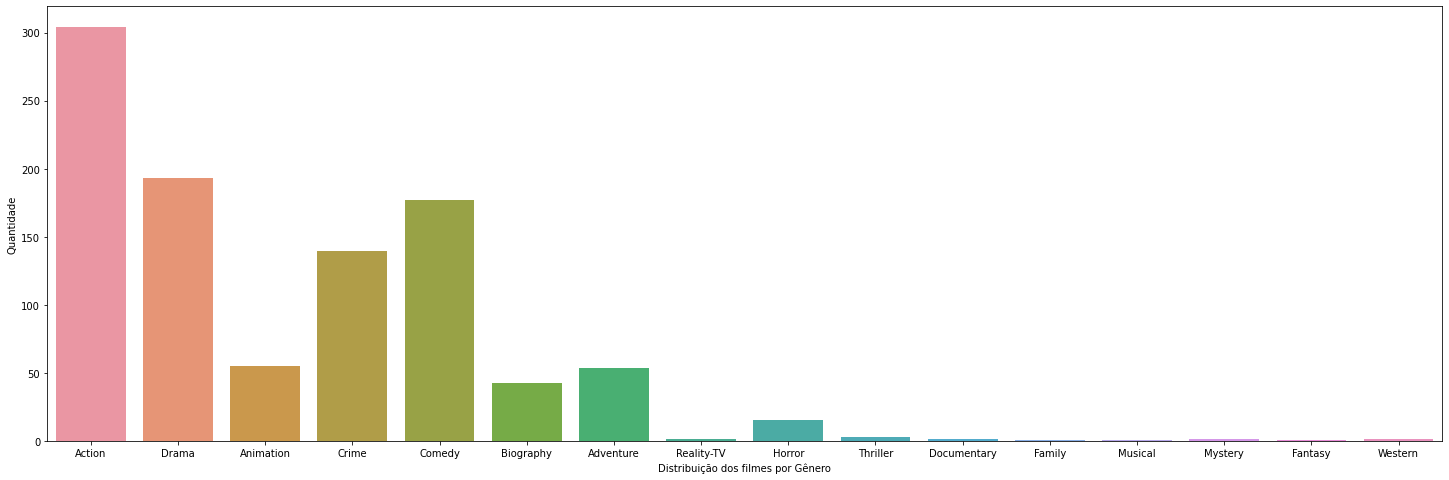

In [21]:
%matplotlib inline
ax = sns.countplot(x = 'dommoviegenre' , data = movies_df)
plt.xlabel("Distribuição dos filmes por Gênero")
plt.ylabel("Quantidade")
fig = plt.gcf()
fig.set_size_inches( 25, 8)
plt.show();

### Criar dataframe com filmes organizados por gênero

In [22]:
movies_genre = movies_df.copy()
movies_genre.set_index(['movietitle'], inplace=True)
groups = dict(tuple(movies_genre.groupby('dommoviegenre')))
df_grouped_genre = pd.concat(groups, axis=0, join='outer')
df_grouped_genre.drop('dommoviegenre', axis = 1, inplace=True)

#### Salvar o dataframe em arquivo .csv

In [23]:
compression_opts = dict(method='zip', archive_name='Moveis Clean Genre.csv')
df_grouped_genre.to_csv('Moveis Clean Genre.zip', index=True, compression=compression_opts, encoding='windows-1252')

## 5 - Criar dataframe com filmes organizados por ano

### Visualizar a distribuição dos filmes por data

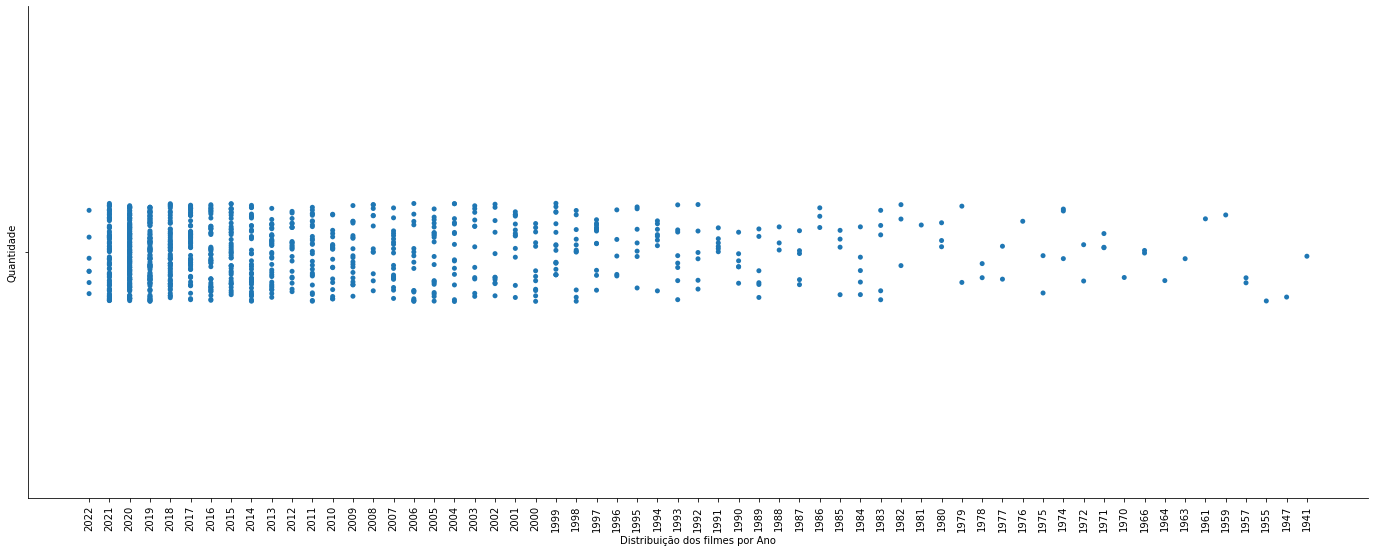

In [24]:
movies_df_sorted = movies_df.sort_values(by=['moviefirstrun'],ascending=False)
ax = sns.catplot(data = movies_df_sorted, x = 'moviefirstrun')
plt.xlabel("Distribuição dos filmes por Ano")
plt.ylabel("Quantidade")
plt.xticks(rotation=90)
fig = plt.gcf()
fig.set_size_inches( 20, 8)
plt.show();

In [25]:
movies_df_sorted.set_index(['movietitle'], inplace=True)
groups = dict(tuple(movies_df_sorted.groupby('moviefirstrun')))
df_grouped_date = pd.concat(groups, axis=0, join='outer')
df_grouped_date.drop('moviefirstrun', axis = 1, inplace=True)

In [26]:
df_grouped_date.head(20)

movieruntime movierating moviescore  \
     movietitle                                                      
1941 Cidadão Kane                       119         8.3        NaN   
1947 Nascido para Matar                  92         7.2        NaN   
1955 Gunsmoke                            60         7.9        NaN   
1957 Perry Mason                         60         8.2        NaN   
     12 Homens e uma Sentença            96         9.0        NaN   
1959 Além da Imaginação                  51         9.0        NaN   
1961 Amor, Sublime Amor                 153         7.5        NaN   
1963 King Kong vs. Godzilla              97         5.9        NaN   
1964 A Feiticeira                        25         7.5        NaN   
1966 Jornada nas Estrelas                50         8.3        NaN   
     Três Homens em Conflito            161         8.8        NaN   
1970 Mary Tyler Moore                    30         8.1        NaN   
1971 Laranja Mecânica                   136         8.3        NaN   
     A Última Sessão de Cinema          118         8.0        NaN   
     Columbo                            100         8.2        NaN   
1972 M*A*S*H                             25         8.4        NaN   
     O Poderoso Chefão                  175         9.2        NaN   
1974 Os Pioneiros                        60         7.4        NaN   
     O Poderoso Chefão II               202         9.0        NaN   
     O Jovem Frankenstein               106         8.0        NaN   

                                                                 moviedescription  \
     movietitle                                                                     
1941 Cidadão Kane               Following the death of publishing tycoon Charl...   
1947 Nascido para Matar         A calculating divorcée risks her chances at we...   
1955 Gunsmoke                   Marshal Matt Dillon keeps the peace in rough a...   
1957 Perry Mason                The cases of a master criminal defense attorne...   
     12 Homens e uma Sentença   A jury holdout attempts to prevent a miscarria...   
1959 Além da Imaginação         Ordinary people find themselves in extraordina...   
1961 Amor, Sublime Amor         Two youngsters from rival New York City gangs ...   
1963 King Kong vs. Godzilla     A newspaper and television station funded by a...   
1964 A Feiticeira               A witch married to an ordinary man cannot resi...   
1966 Jornada nas Estrelas       In the 23rd Century, Captain James T. Kirk and...   
     Três Homens em Conflito    A bounty hunting scam joins two men in an unea...   
1970 Mary Tyler Moore           The lives and trials of a young single woman a...   
1971 Laranja Mecânica           In the future, a sadistic gang leader is impri...   
     A Última Sessão de Cinema  In 1951, a group of high schoolers come of age...   
     Columbo                    Los Angeles homicide detective Lieutenant Colu...   
1972 M*A*S*H                    The staff of an Army hospital in the Korean Wa...   
     O Poderoso Chefão          An organized crime dynasty's aging patriarch t...   
1974 Os Pioneiros               The life and adventures of the Ingalls family ...   
     O Poderoso Chefão II       The early life and career of Vito Corleone in ...   
     O Jovem Frankenstein       An American grandson of the infamous scientist...   

                                               moviedirector movievotes  \
     movietitle                                                           
1941 Cidadão Kane                               Orson Welles     403411   
1947 Nascido para Matar                          Robert Wise       4696   
1955 Gunsmoke                                            NaN       5095   
1957 Perry Mason                                         NaN       5160   
     12 Homens e uma Sentença                   Sidney Lumet     689981   
1959 Além da Imaginação                                  NaN      71193   
1961 Amor, Sublime 

#### Salvar o dataframe em arquivo .csv

In [27]:
compression_opts = dict(method='zip', archive_name='Moveis Clean Date.csv')
df_grouped_date.to_csv('Moveis Clean Date.zip', index=True, compression=compression_opts, encoding='windows-1252')